### Packages Required

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA  

In [162]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE,f_regression,SelectKBest,f_classif
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
#pip install lightgbm
import lightgbm as lgb

### Datasets

In [329]:
Marketing_Spend = pd.read_csv('C:/Users/Nithin/Downloads/14. Capstone Case Study - Finding-Marketing-Insights/Datasets/Marketing_Spend.csv')
Discount_Coupon = pd.read_csv('C:/Users/Nithin/Downloads/14. Capstone Case Study - Finding-Marketing-Insights/Datasets/Discount_Coupon.csv')
Online_Sales = pd.read_csv('C:/Users/Nithin/Downloads/14. Capstone Case Study - Finding-Marketing-Insights/Datasets/Online_Sales.csv')

In [13]:
Tax_amount = pd.read_excel('C:/Users/Nithin/Downloads/14. Capstone Case Study - Finding-Marketing-Insights/Datasets/Tax_amount.xlsx')
CustomersData = pd.read_excel('C:/Users/Nithin/Downloads/14. Capstone Case Study - Finding-Marketing-Insights/Datasets/CustomersData.xlsx')

### Data Prep

In [315]:
Marketing_Spend.columns = Marketing_Spend.columns.str.replace(' ','')
Discount_Coupon.columns = Discount_Coupon.columns.str.replace(' ','')
Online_Sales.columns = Online_Sales.columns.str.replace(' ','')
Tax_amount.columns = Tax_amount.columns.str.replace(' ','')
CustomersData.columns = CustomersData.columns.str.replace(' ','')

In [330]:
Online_Sales.Transaction_Date = pd.to_datetime(Online_Sales.Transaction_Date,format='%Y%m%d')
Online_Sales['Month'] = Online_Sales.Transaction_Date.dt.month

In [317]:
Discount_Coupon.Month = pd.to_datetime(Discount_Coupon.Month,format='%b').dt.month

In [318]:
cust_final = pd.merge(Online_Sales,CustomersData,how='left',on='CustomerID')
cust_final = pd.merge(cust_final,Tax_amount,how='left',on='Product_Category')
cust_final = pd.merge(cust_final,Discount_Coupon,how='left',on=['Product_Category','Month'])

In [319]:
Marketing_Spend.Date = pd.to_datetime(Marketing_Spend.Date)

In [320]:
cust_final = pd.merge(cust_final,Marketing_Spend,how='left',left_on='Transaction_Date',right_on='Date')

In [321]:
cust_final.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Month,Gender,Location,Tenure_Months,GST,Coupon_Code,Discount_pct,Date,Offline_Spend,Online_Spend
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,...,1,M,Chicago,12,0.10,ELEC10,10.0,2019-01-01,4500,2424.5
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,...,1,M,Chicago,12,0.10,ELEC10,10.0,2019-01-01,4500,2424.5
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,...,1,M,Chicago,12,0.10,OFF10,10.0,2019-01-01,4500,2424.5
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,...,1,M,Chicago,12,0.18,SALE10,10.0,2019-01-01,4500,2424.5
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,...,1,M,Chicago,12,0.18,AIO10,10.0,2019-01-01,4500,2424.5


**--Invoice Amount**

In [21]:
cust_final['Invoice_amnt'] = ((cust_final.Avg_Price * cust_final.Quantity) + (1 - cust_final.Discount_pct / 100) + (1 + cust_final.GST ) + cust_final.Delivery_Charges)

In [22]:
cust_final.Invoice_amnt

0        162.21
1        162.21
2         10.55
3         96.23
4         25.08
          ...  
52919    129.60
52920     57.30
52921    160.18
52922    410.90
52923    343.87
Name: Invoice_amnt, Length: 52924, dtype: float64

**--New Customers accuired in a month**

In [23]:
cust_final['year_month'] = cust_final.Transaction_Date.apply(lambda x: pd.Timestamp.strftime(x , format = "%Y-%m"))

In [24]:
new_cust = cust_final.loc[:,['CustomerID','year_month']]
new_cust.drop_duplicates(subset='CustomerID' , inplace= True)

<AxesSubplot:xlabel='year_month'>

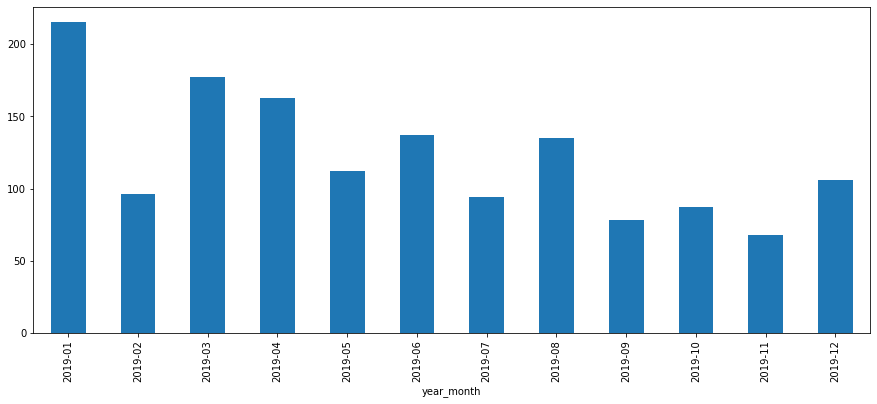

In [25]:
new_cust = new_cust.groupby('year_month')['CustomerID'].count()
new_cust.plot(kind='bar',figsize = (15,6))

**--Retented customer based on month**

In [26]:
old_cust = cust_final.groupby('year_month')['CustomerID'].count().reset_index()

In [27]:
reten = pd.merge(new_cust,old_cust,how='left',on='year_month')
reten['retented'] = reten.CustomerID_y-reten.CustomerID_x

<AxesSubplot:xlabel='year_month'>

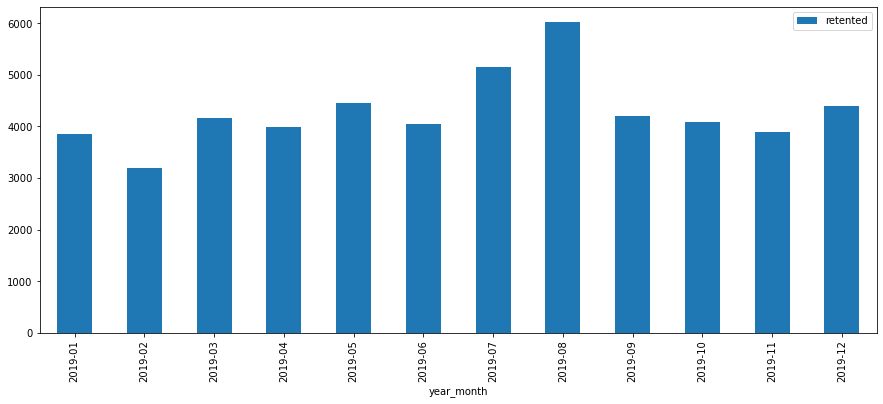

In [28]:
reten.plot(kind='bar',x='year_month',y='retented',figsize = (15,6))

**--revenues from existing/new customers on month on month basis**

In [29]:
cust_final['Sales_amt'] = ((cust_final.Quantity*cust_final.Avg_Price)*((1-cust_final.Discount_pct/100)))

<AxesSubplot:xlabel='year_month'>

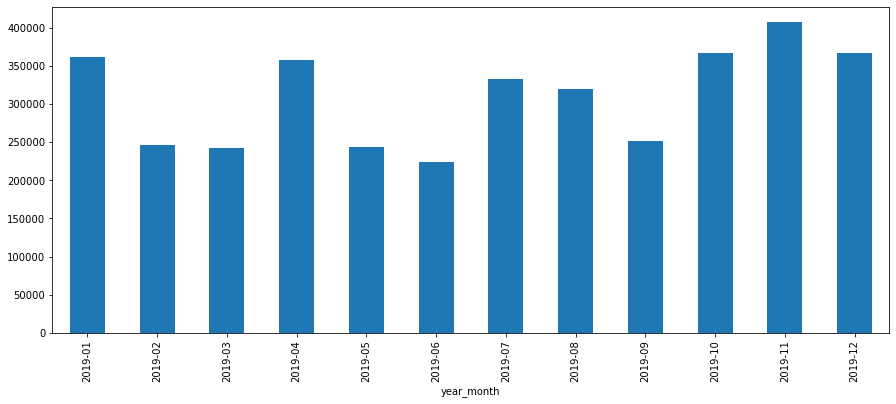

In [30]:
cust_final.groupby('year_month')['Sales_amt'].sum().plot(kind='bar',figsize = (15,6))

**--discounts playing role in the revenues**

<AxesSubplot:xlabel='Discount_pct'>

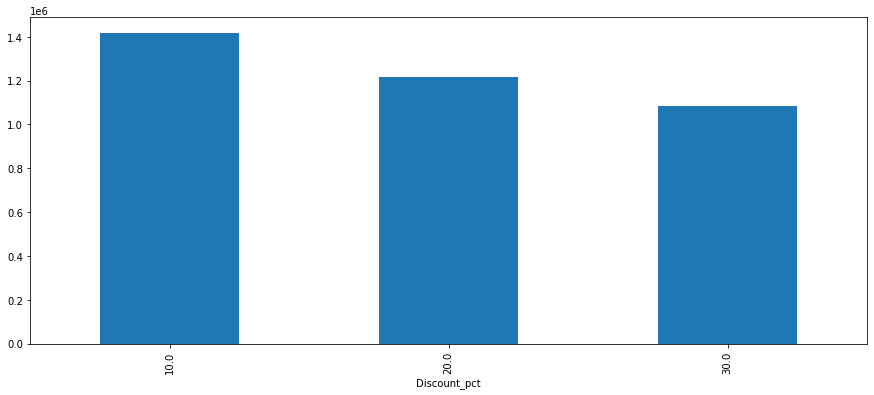

In [31]:
cust_final.groupby('Discount_pct')['Sales_amt'].sum().plot(kind = 'bar',figsize = (15,6))

**--Analyse KPI’s like Revenue, number of orders, average order value, number of customers (existing/new), quantity, by category, by month, by week, by day**

$Invoice Amount$

<AxesSubplot:xlabel='year_month'>

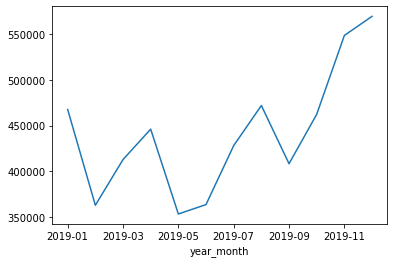

In [32]:
cust_final.groupby('year_month')['Invoice_amnt'].sum().plot(kind='line')

C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/1563564527.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Invoice_amnt',aggfunc='sum').plot(kind='line')


<AxesSubplot:xlabel='Transaction_Date'>

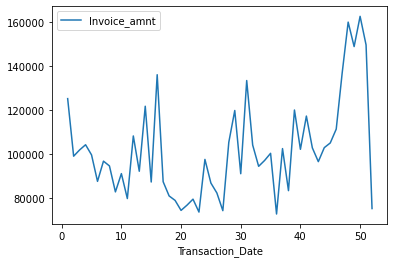

In [33]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Invoice_amnt',aggfunc='sum').plot(kind='line')

<AxesSubplot:xlabel='Transaction_Date'>

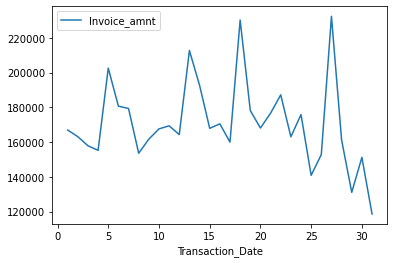

In [34]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.day,values='Invoice_amnt',aggfunc='sum').plot(kind='line')

$Sales Amount$

<AxesSubplot:xlabel='year_month'>

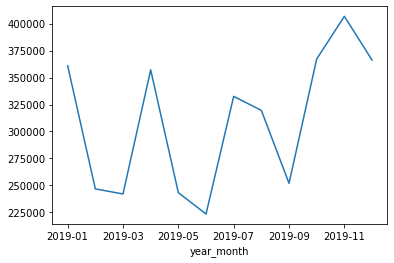

In [35]:
cust_final.groupby('year_month')['Sales_amt'].sum().plot(kind='line')

C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/1168954954.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Sales_amt',aggfunc='sum').plot(kind='line')


<AxesSubplot:xlabel='Transaction_Date'>

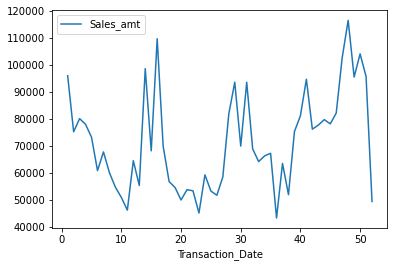

In [36]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Sales_amt',aggfunc='sum').plot(kind='line')

<AxesSubplot:xlabel='Transaction_Date'>

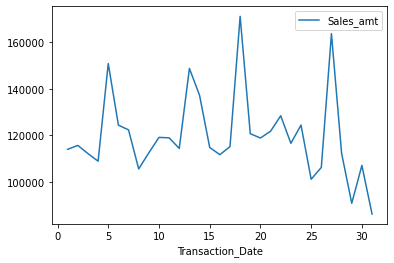

In [37]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.day,values='Sales_amt',aggfunc='sum').plot(kind='line')

$Quantity$

<AxesSubplot:xlabel='year_month'>

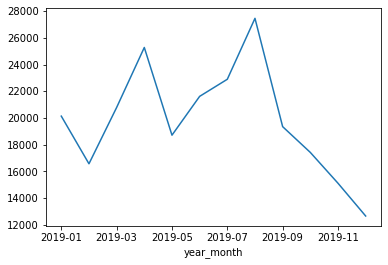

In [38]:
cust_final.groupby('year_month')['Quantity'].sum().plot(kind='line')

C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/1018284971.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Quantity',aggfunc='sum').plot(kind='line')


<AxesSubplot:xlabel='Transaction_Date'>

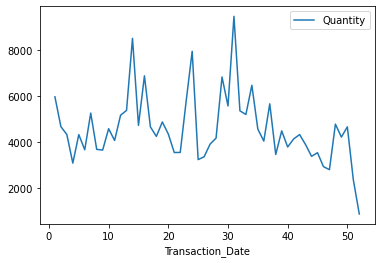

In [39]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.week,values='Quantity',aggfunc='sum').plot(kind='line')

<AxesSubplot:xlabel='Transaction_Date'>

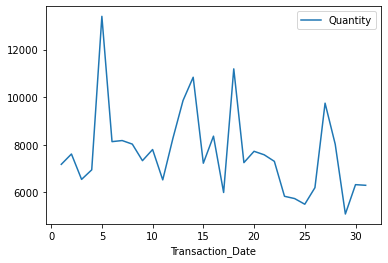

In [40]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.day,values='Quantity',aggfunc='sum').plot(kind='line')

$Customers$

In [41]:
reten.rename(columns={'CustomerID_y':'old','CustomerID_x':'new'},inplace=True)
reten.rename(columns={'old':'all','retented':'old'},inplace=True)

In [42]:
reten

,year_month,new,all,old
0,2019-01,215,4063,3848
1,2019-02,96,3284,3188
2,2019-03,177,4346,4169
3,2019-04,163,4150,3987
4,2019-05,112,4572,4460
5,2019-06,137,4193,4056
6,2019-07,94,5251,5157
7,2019-08,135,6150,6015
8,2019-09,78,4288,4210
9,2019-10,87,4164,4077


<AxesSubplot:>

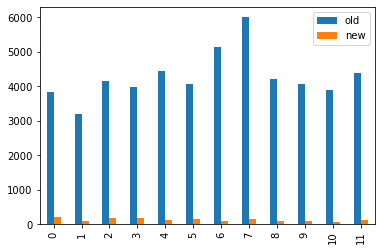

In [43]:
reten.loc[:,['old','new']].plot(kind='bar')

**--Understand the trends/seasonality of sales by category, location, month**

<AxesSubplot:xlabel='Transaction_Date'>

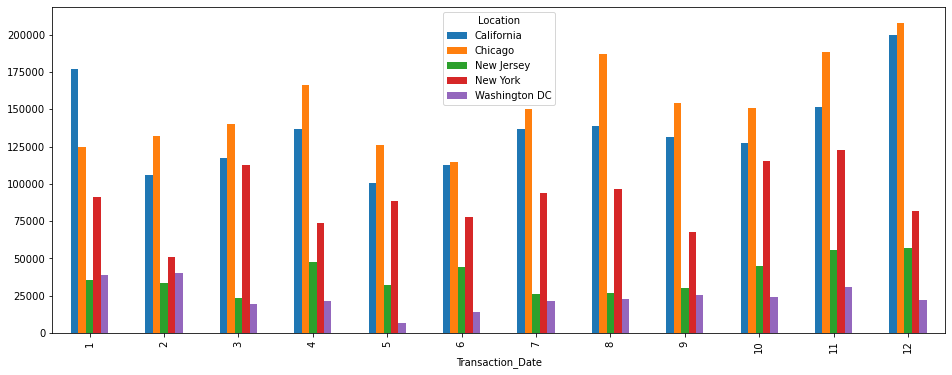

In [44]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.month,columns='Location',values='Invoice_amnt',aggfunc='sum').plot(kind='bar',figsize=(16,6))

<AxesSubplot:ylabel='Transaction_Date'>

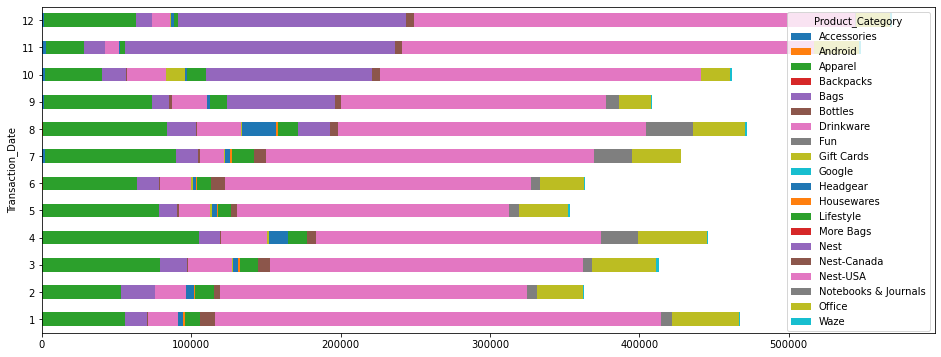

In [45]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.month,columns='Product_Category',values='Invoice_amnt',aggfunc='sum').plot(kind='barh',stacked=True,figsize=(16,6))

**--How number order varies and sales with different days**

<AxesSubplot:ylabel='Transaction_Date'>

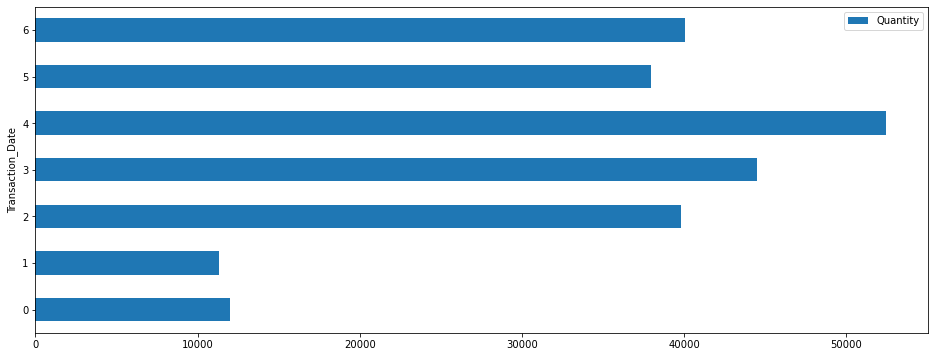

In [46]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.weekday,values='Quantity',aggfunc='sum').plot(kind='barh',figsize=(16,6))

<AxesSubplot:ylabel='Transaction_Date'>

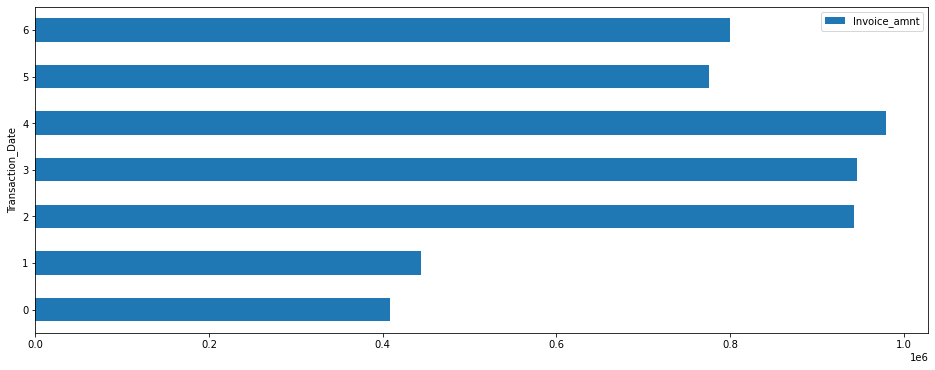

In [47]:
pd.pivot_table(cust_final,index=cust_final.Transaction_Date.dt.weekday,values='Invoice_amnt',aggfunc='sum').plot(kind='barh',figsize=(16,6))

**--Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month**

$Mktg Spends$

In [48]:
cust_final['total_mktg_spend'] = (cust_final.Offline_Spend + cust_final.Online_Spend)

<AxesSubplot:xlabel='year_month'>

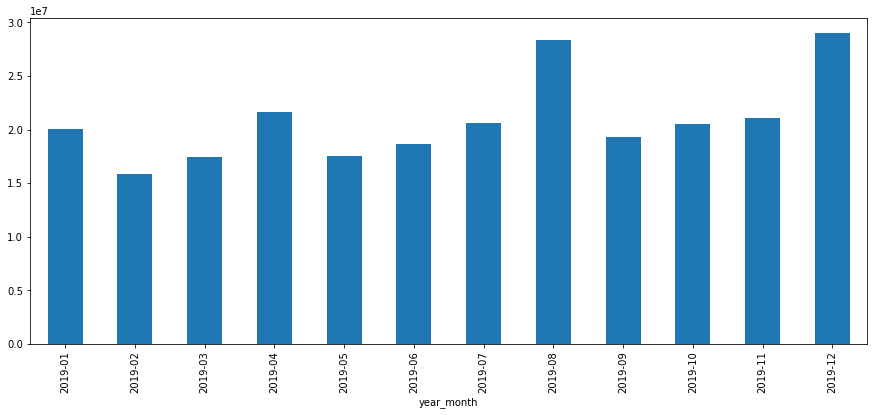

In [49]:
cust_final.groupby('year_month')['total_mktg_spend'].sum().plot(kind='bar',figsize=(15,6))

$Delivery Charges$

In [50]:
devlivery_month = cust_final.groupby('year_month')['total_mktg_spend'].sum()/(cust_final.Delivery_Charges.sum())

<AxesSubplot:ylabel='total_mktg_spend'>

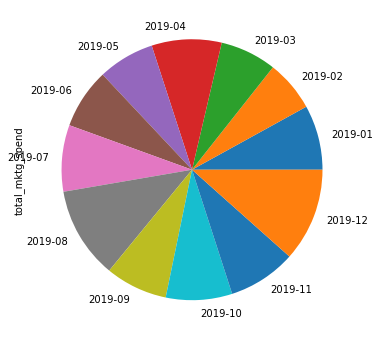

In [51]:
devlivery_month.plot(kind='pie',figsize=(12,6))

**--How marketing spend is impacting on revenue?**

In [52]:
impact = cust_final.loc[:,['year_month','Invoice_amnt','total_mktg_spend']]

<AxesSubplot:ylabel='year_month'>

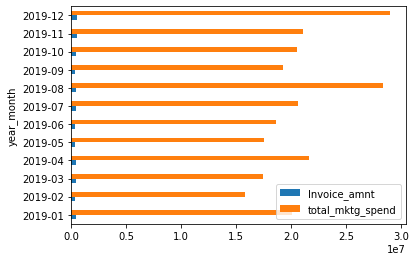

In [53]:
pd.pivot_table(impact,index='year_month',values=['Invoice_amnt','total_mktg_spend'],aggfunc='sum').plot(kind='barh')

**--Which product was appeared in the transactions?**

In [54]:
cust_final.groupby('Product_Category').Invoice_amnt.sum().sort_values(ascending=False).head(3)

Product_Category
Nest-USA    2680485.05
Apparel      803892.02
Nest         538287.80
Name: Invoice_amnt, dtype: float64

**--Which product was purchased mostly based on the quantity**

In [55]:
cust_final.groupby('Product_Category').Quantity.sum().sort_values(ascending=False).head(3)

Product_Category
Office       88383
Apparel      32438
Drinkware    30501
Name: Quantity, dtype: int64

### Segmentation

**--Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver**

$Value Based$

In [56]:
vb = cust_final.copy()

In [57]:
vb['decile'] = pd.qcut(vb.Invoice_amnt,3,labels=False)

In [58]:
vb.decile = np.where(vb.decile==0,'Silver',
            np.where(vb.decile==1,'Gold',
            np.where(vb.decile==2,'Premium','Premium')))

In [59]:
vb.head(10)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Coupon_Code,Discount_pct,Date,Offline_Spend,Online_Spend,Invoice_amnt,year_month,Sales_amt,total_mktg_spend,decile
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,...,ELEC10,10.0,2019-01-01,4500,2424.5,162.21,2019-01,138.339,6924.5,Premium
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,...,ELEC10,10.0,2019-01-01,4500,2424.5,162.21,2019-01,138.339,6924.5,Premium
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,...,OFF10,10.0,2019-01-01,4500,2424.5,10.55,2019-01,1.845,6924.5,Silver
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,...,SALE10,10.0,2019-01-01,4500,2424.5,96.23,2019-01,78.885,6924.5,Gold
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,...,AIO10,10.0,2019-01-01,4500,2424.5,25.08,2019-01,14.850,6924.5,Gold
5,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,...,AIO10,10.0,2019-01-01,4500,2424.5,85.83,2019-01,69.525,6924.5,Gold
6,17850,16682,2019-01-01,GGOEGDHC018299,Google 22 oz Water Bottle,Drinkware,15,3.08,6.5,Not Used,...,EXTRA10,10.0,2019-01-01,4500,2424.5,54.78,2019-01,41.580,6924.5,Gold
7,17850,16682,2019-01-01,GGOEGDHG014499,Google Infuser-Top Water Bottle,Drinkware,15,10.31,6.5,Clicked,...,EXTRA10,10.0,2019-01-01,4500,2424.5,163.23,2019-01,139.185,6924.5,Premium
8,17850,16682,2019-01-01,GGOEGDWC020199,Engraved Ceramic Google Mug,Drinkware,5,9.27,6.5,Used,...,EXTRA10,10.0,2019-01-01,4500,2424.5,54.93,2019-01,41.715,6924.5,Gold
9,13047,16682,2019-01-01,GGOEGGOA017399,Maze Pen,Office,52,0.98,6.5,Used,...,OFF10,10.0,2019-01-01,4500,2424.5,59.46,2019-01,45.864,6924.5,Gold


$RFM$

In [60]:
date = dt.datetime(2020, 2, 20)

In [61]:
rfm_df = cust_final.copy()

In [62]:
rfm = rfm_df.groupby('CustomerID').agg({'Transaction_ID':'count',
                                                'Sales_amt':'sum'}).reset_index().rename(columns={'Transaction_ID': 'frequency', 'Sales_amt': 'monetary'})
rfm

,CustomerID,frequency,monetary
0,12346,2,21.693
1,12347,60,9930.649
2,12348,23,1142.502
3,12350,17,952.049
4,12356,36,1009.729
...,...,...,...
1463,18259,7,474.075
1464,18260,40,1753.041
1465,18269,8,88.466
1466,18277,1,268.200


In [63]:
rfm_recency = rfm_df.loc[:,['CustomerID','Transaction_Date']]
rfm_recency = rfm_recency.drop_duplicates(subset='CustomerID', keep='last')

In [64]:
rfm_recency['recency'] = (date - rfm_recency.Transaction_Date).dt.days

In [65]:
rfm_df = pd.merge(rfm_recency, rfm, how= 'right', on= 'CustomerID')

In [66]:
rfm_df.drop(columns='Transaction_Date', inplace=True)
rfm_df.head()

,CustomerID,recency,frequency,monetary
0,12346,158,2,21.693
1,12347,110,60,9930.649
2,12348,124,23,1142.502
3,12350,68,17,952.049
4,12356,158,36,1009.729


In [68]:
quantiles = rfm_df[['frequency','monetary','recency' ]].quantile(q=[0.25,0.5,0.75])
quantiles

,frequency,monetary,recency
0.25,10.0,509.48475,106.0
0.50,21.0,1406.88100,182.0
0.75,46.0,3142.38125,271.0


In [69]:
#We create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good.
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [70]:
rfm_df['R_Quartile'] = rfm_df['recency'].apply(RClass, args=('recency',quantiles,))
rfm_df['F_Quartile'] = rfm_df['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfm_df['M_Quartile'] = rfm_df['monetary'].apply(FMClass, args=('monetary',quantiles,))

In [71]:
rfm_df.head()

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile
0,12346,158,2,21.693,2,4,4
1,12347,110,60,9930.649,2,1,1
2,12348,124,23,1142.502,2,2,3
3,12350,68,17,952.049,1,3,3
4,12356,158,36,1009.729,2,2,3


In [72]:
rfm_df1=rfm_df.assign(R_rfm=np.nan, FM_rfm =np.nan)
rfm_df1.R_rfm[rfm_df['R_Quartile']==4] = "3_Churn"
rfm_df1.R_rfm[rfm_df['R_Quartile']==2] = "2_At_Risk"
rfm_df1.R_rfm[rfm_df['R_Quartile']==3] = "2_At_Risk"
rfm_df1.R_rfm[rfm_df['R_Quartile']==1] = "1_Active"

rfm_df1.FM_rfm[(rfm_df['F_Quartile']==3) & (rfm_df['M_Quartile']==1)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==4) & (rfm_df['M_Quartile']==1)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==2) & (rfm_df['M_Quartile']==2)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==2) & (rfm_df['M_Quartile']==1)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==3) & (rfm_df['M_Quartile']==2)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==4) & (rfm_df['M_Quartile']==2)] = "1_Silver"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==1) & (rfm_df['M_Quartile']==3)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==2) & (rfm_df['M_Quartile']==3)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==3) & (rfm_df['M_Quartile']==3)] = "1_Silver"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==4) & (rfm_df['M_Quartile']==3)] = "1_Silver"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==1) & (rfm_df['M_Quartile']==4)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==1) & (rfm_df['M_Quartile']==2)] = "2_Gold"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==2) & (rfm_df['M_Quartile']==4)] = "1_Silver"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==3) & (rfm_df['M_Quartile']==4)] = "1_Silver"
rfm_df1.FM_rfm[(rfm_df['F_Quartile']==4) & (rfm_df['M_Quartile']==4)] = "0_Standard"

rfm_df1.FM_rfm.fillna("4_Premium", inplace=True)

C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/2246897217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df1.R_rfm[rfm_df['R_Quartile']==4] = "3_Churn"
C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/2246897217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df1.R_rfm[rfm_df['R_Quartile']==2] = "2_At_Risk"
C:\Users\Nithin\AppData\Local\Temp/ipykernel_11728/2246897217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [73]:
cols = ['monetary','recency','frequency']

In [74]:
rfm_df1

,CustomerID,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,R_rfm,FM_rfm
0,12346,158,2,21.693,2,4,4,2_At_Risk,0_Standard
1,12347,110,60,9930.649,2,1,1,2_At_Risk,4_Premium
2,12348,124,23,1142.502,2,2,3,2_At_Risk,2_Gold
3,12350,68,17,952.049,1,3,3,1_Active,1_Silver
4,12356,158,36,1009.729,2,2,3,2_At_Risk,2_Gold
...,...,...,...,...,...,...,...,...,...
1463,18259,321,7,474.075,4,4,4,3_Churn,0_Standard
1464,18260,138,40,1753.041,2,2,2,2_At_Risk,2_Gold
1465,18269,245,8,88.466,3,4,4,2_At_Risk,0_Standard
1466,18277,120,1,268.200,2,4,4,2_At_Risk,0_Standard


In [75]:
rfm_df1.groupby(['R_rfm', 'FM_rfm']).apply(lambda x: x[cols].mean()).T

R_rfm        1_Active                                         2_At_Risk  \
FM_rfm     0_Standard    1_Silver       2_Gold    4_Premium  0_Standard   
monetary   242.059257  826.715143  2393.159021  9088.011212  172.849157   
recency     72.457143   74.528571    78.020548    77.016949  191.444444   
frequency    4.371429   12.928571    30.041096   115.491525    4.601307   

R_rfm                                               3_Churn              \
FM_rfm       1_Silver       2_Gold    4_Premium  0_Standard    1_Silver   
monetary   760.850944  2190.131802  6561.446391  168.305390  812.445667   
recency    187.635897   181.988095   169.360902  339.047619  339.419048   
frequency   13.415385    34.793651    97.466165    3.552381   12.819048   

R_rfm                                
FM_rfm          2_Gold    4_Premium  
monetary   2162.754414  6379.922956  
recency     334.837838   350.777778  
frequency    31.387387    79.955556

$K Means$

In [76]:
rfm_df2 = rfm_df.loc[:,['recency','frequency','monetary']]
rfm_df2.head() 

,recency,frequency,monetary
0,158,2,21.693
1,110,60,9930.649
2,124,23,1142.502
3,68,17,952.049
4,158,36,1009.729


**--Scaling Data**

In [322]:
sc = StandardScaler()
sc = pd.DataFrame(sc.fit_transform(rfm_df2),columns=rfm_df2.columns)
sc.head(5)

,recency,frequency,monetary
0,-0.365961,-0.669410,-0.614642
1,-0.837001,0.470788,1.811083
2,-0.699614,-0.256579,-0.340266
3,-1.249160,-0.374531,-0.386889
4,-0.365961,-0.001018,-0.372769


**--Model**

In [77]:
km = KMeans(n_clusters=4,random_state=1234)
km = km.fit(rfm_df2)

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [78]:
pd.Series(km.labels_).value_counts().sort_index()

0    1142
1       5
2     289
3      32
dtype: int64

**--Evaluation**

$Silhouette score$

In [325]:
silhouette_score(rfm_df2,km.labels_)

0.6836688054269123

In [79]:
#Loop of k = 2 to 20
k_range = range(2,21)
silhouette_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(rfm_df2)
    silhouette_scores.append(silhouette_score(rfm_df2, km.labels_))

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

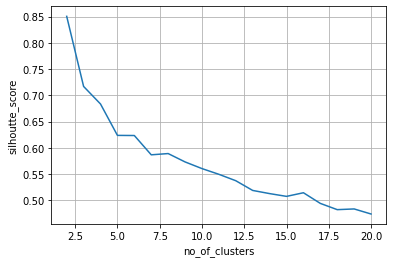

In [80]:
plt.plot(k_range,silhouette_scores)
plt.xlabel('no_of_clusters')
plt.ylabel('silhoutte_score')
plt.grid(True)

$WCSS Score$

In [329]:
k_range = range(2,21)
wcss_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=1234)
    km.fit(rfm_df2)
    wcss_scores.append(km.inertia_)

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

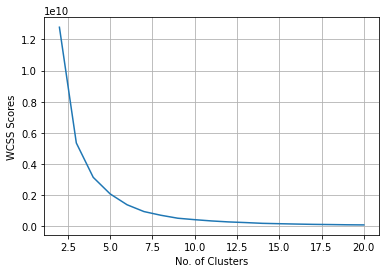

In [330]:
plt.plot(k_range,wcss_scores)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS Scores')
plt.grid(True)

In [81]:
# We have decided k value between 3 to 8

km_3 = KMeans(n_clusters=3, random_state=123).fit(rfm_df2)
km_4 = KMeans(n_clusters=4, random_state=123).fit(rfm_df2)
km_5 = KMeans(n_clusters=5, random_state=123).fit(rfm_df2)
km_6 = KMeans(n_clusters=6, random_state=123).fit(rfm_df2)
km_7 = KMeans(n_clusters=7, random_state=123).fit(rfm_df2)
km_8 = KMeans(n_clusters=8, random_state=123).fit(rfm_df2)

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

In [84]:
pd.Series(km_3.labels_).value_counts().sort_index()

0    1236
1     226
2       6
dtype: int64

In [85]:

pd.Series(km_4.labels_).value_counts().sort_index()

0     289
1    1142
2      32
3       5
dtype: int64

In [86]:
pd.Series(km_5.labels_).value_counts().sort_index()

0    932
1    129
2      5
3     27
4    375
dtype: int64

In [87]:
pd.Series(km_6.labels_).value_counts().sort_index()

0    929
1      2
2     31
3    131
4      4
5    371
dtype: int64

In [88]:
pd.Series(km_7.labels_).value_counts().sort_index()

0    412
1     26
2      4
3     92
4    731
5      2
6    201
dtype: int64

In [89]:

pd.Series(km_8.labels_).value_counts().sort_index()

0    752
1     88
2      4
3    399
4     10
5      2
6    192
7     21
dtype: int64

In [95]:
rfm_df2['Cluster_3'] = km_3.labels_
rfm_df2['Cluster_4'] = km_4.labels_
rfm_df2['Cluster_5'] = km_5.labels_
rfm_df2['Cluster_6'] = km_6.labels_
rfm_df2['Cluster_7'] = km_7.labels_
rfm_df2['Cluster_8'] = km_8.labels_

In [90]:
print('km_3 =',silhouette_score(rfm_df2, km_3.labels_))
print('km_4 =',silhouette_score(rfm_df2, km_4.labels_))
print('km_5 =',silhouette_score(rfm_df2, km_5.labels_))
print('km_6 =',silhouette_score(rfm_df2, km_6.labels_))
print('km_7 =',silhouette_score(rfm_df2, km_7.labels_))
print('km_8 =',silhouette_score(rfm_df2, km_8.labels_))

km_3 = 0.7171422387181583
km_4 = 0.6836688054269123
km_5 = 0.6238517331561874
km_6 = 0.623587270955373
km_7 = 0.5867963077724244
km_8 = 0.589188084004382


In [97]:
predect_rfm = pd.DataFrame(rfm_df2.Cluster_7 ).rename(columns={'Cluster_7':'Pred_rfm'})
rfm_kmeans = pd.concat([rfm_df, predect_rfm], axis=1)

In [98]:
rfm_kmeans.drop(columns = ['R_Quartile','F_Quartile','M_Quartile'], axis=1,inplace = True)
rfm_kmeans

,CustomerID,recency,frequency,monetary,Pred_rfm
0,12346,158,2,21.693,4
1,12347,110,60,9930.649,3
2,12348,124,23,1142.502,4
3,12350,68,17,952.049,4
4,12356,158,36,1009.729,4
...,...,...,...,...,...
1463,18259,321,7,474.075,4
1464,18260,138,40,1753.041,0
1465,18269,245,8,88.466,4
1466,18277,120,1,268.200,4


### 4.	Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

In [104]:
df_cust = cust_final[['CustomerID','Transaction_Date']]

In [106]:
df_max = df_cust.groupby('CustomerID')['Transaction_Date'].max().reset_index()
df_min = df_cust.groupby('CustomerID')['Transaction_Date'].min().reset_index()

In [109]:
df = pd.merge(df_max,df_min,on='CustomerID',how='left',suffixes=('_max','_min'))

In [114]:
df['days'] = (df.Transaction_Date_max-df.Transaction_Date_min).dt.days

In [134]:
pd.qcut(pd.Series(df.days),q=4,duplicates='drop').value_counts()

(-0.001, 0.5]     734
(0.5, 121.0]      369
(121.0, 358.0]    365
Name: days, dtype: int64

In [138]:
df['cust_life'] = np.where(df.days<= 0.5,1,
                    np.where(df.days<=121,2,3))

In [149]:
df_cust = pd.merge(df,rfm_df1,how='left' ,on='CustomerID')

In [152]:
df_cust.drop(columns=['Transaction_Date_max','Transaction_Date_min'],inplace=True)

In [155]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  1468 non-null   int64  
 1   days        1468 non-null   int64  
 2   cust_life   1468 non-null   int32  
 3   recency     1468 non-null   int64  
 4   frequency   1468 non-null   int64  
 5   monetary    1468 non-null   float64
 6   R_Quartile  1468 non-null   int64  
 7   F_Quartile  1468 non-null   int64  
 8   M_Quartile  1468 non-null   int64  
 9   R_rfm       1468 non-null   object 
 10  FM_rfm      1468 non-null   object 
dtypes: float64(1), int32(1), int64(7), object(2)
memory usage: 131.9+ KB


In [156]:
df_cust = pd.get_dummies(df_cust, columns=['R_rfm'], drop_first=True, prefix='R_rfm')
df_cust = pd.get_dummies(df_cust, columns=['FM_rfm'], drop_first=True, prefix='FM_rfm')

In [158]:
from imblearn.over_sampling import SMOTE

In [159]:
x = df_cust[df_cust.columns.difference(['cust_life'])]
y = df_cust.cust_life

In [160]:
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(x, y)

In [161]:
df_cust1 = pd.concat([resampled_X, resampled_y], axis=1)

In [163]:
df_cust1.cust_life

,CustomerID,FM_rfm_1_Silver,FM_rfm_2_Gold,FM_rfm_4_Premium,F_Quartile,M_Quartile,R_Quartile,R_rfm_2_At_Risk,R_rfm_3_Churn,days,frequency,monetary,recency,cust_life
0,12346,0,0,0,4,4,2,1,0,0,2,21.693000,158,1
1,12347,0,0,1,1,1,2,1,0,223,60,9930.649000,110,3
2,12348,0,1,0,2,3,2,1,0,119,23,1142.502000,124,2
3,12350,1,0,0,3,3,1,0,0,0,17,952.049000,68,1
4,12356,0,1,0,2,3,2,1,0,0,36,1009.729000,158,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,12471,0,0,0,2,3,2,1,0,154,28,1006.810463,201,3
2198,14403,0,0,0,2,3,1,0,0,179,21,1319.799569,89,3
2199,13134,0,0,1,1,1,1,0,0,261,125,16418.967214,72,3
2200,14232,0,0,0,2,3,1,0,0,252,21,654.925714,73,3


**--Select K Best**

In [164]:
X = df_cust1[df_cust1.columns.difference(['cust_life'])]
skb = SelectKBest(f_classif, k=10).fit(X, df_cust1[['cust_life']] )

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [165]:
feat = list(X.columns[skb.get_support()])

**--VIF**

In [168]:
feature=feat.copy()
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(df_cust1[feature].values,i) for i in range(df_cust1[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(df_cust1[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])

In [173]:
df_cust1_fn = df_cust1[feature]

In [175]:
df_cust1_fn = pd.concat([df_cust1_fn,df_cust1.cust_life],axis = 1)

### Train Test Split

In [176]:
X = df_cust1_fn.drop('cust_life',axis=1)
Y = df_cust1_fn.cust_life

In [177]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=123)

In [179]:
sc = StandardScaler()
train_x_std = sc.fit_transform(train_x)
train_x_std = pd.DataFrame(train_x_std,columns=train_x.columns)
test_x_std = sc.transform(test_x)
test_x_std = pd.DataFrame(test_x_std,columns=test_x.columns)

### Random Forest

In [188]:
params = {'n_estimators':[50,100] ,
          'max_depth':[2,3,4], 
          'max_features':[4,5,6]}

In [189]:
grd = GridSearchCV(RandomForestClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [2, 3, 4], 'max_features': [4, 5, 6],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [190]:
grd.best_params_

{'max_depth': 2, 'max_features': 4, 'n_estimators': 50}

In [191]:
M_rf = RandomForestClassifier(n_estimators=50,n_jobs=1,max_depth=2,max_features=4)
M_rf.fit(train_x_std,train_y)

RandomForestClassifier(max_depth=2, max_features=4, n_estimators=50, n_jobs=1)

In [192]:
train_pred = M_rf.predict(train_x_std)
test_pred = M_rf.predict(test_x_std)

**--Evaluation**

In [193]:
#Evaluation --> Train
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.0
MSE: 0.0
RMSE: 0.0
Class_Report:               precision    recall  f1-score   support

           1       1.00      1.00      1.00       514
           2       1.00      1.00      1.00       522
           3       1.00      1.00      1.00       505

    accuracy                           1.00      1541
   macro avg       1.00      1.00      1.00      1541
weighted avg       1.00      1.00      1.00      1541



In [194]:
#Evaluation --> Test
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.0
MSE: 0.0
RMSE: 0.0
Class_Report:               precision    recall  f1-score   support

           1       1.00      1.00      1.00       220
           2       1.00      1.00      1.00       212
           3       1.00      1.00      1.00       229

    accuracy                           1.00       661
   macro avg       1.00      1.00      1.00       661
weighted avg       1.00      1.00      1.00       661



### 5.Cross-Selling (Which products are selling together)

In [ ]:
#pip install mlxtend

In [197]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [199]:
Online_Sales.Product_Description.value_counts()

Nest Learning Thermostat 3rd Gen-USA - Stainless Steel         3511
Nest Cam Outdoor Security Camera - USA                         3328
Nest Cam Indoor Security Camera - USA                          3230
Google Sunglasses                                              1523
Nest Protect Smoke + CO White Battery Alarm-USA                1361
                                                               ... 
Google Tee Red                                                    2
Google Women's Colorblock Tee White                               1
Compact Journal with Recycled Pages                               1
Android Women's Short Sleeve Tri-blend Badge Tee Light Blue       1
Google Large Standard Journal Grey                                1
Name: Product_Description, Length: 404, dtype: int64

In [201]:
Online_Sales.Product_Description = Online_Sales.Product_Description.str.strip()

In [206]:
basket = Online_Sales.groupby(['CustomerID', 'Product_Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('CustomerID')

In [205]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 

In [209]:
basket_set = basket.applymap(encode_units)

In [212]:
freq = apriori(basket_set, min_support=0.2, use_colnames=True)

C:\Users\Nithin\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [213]:
freq.sort_values(by='support', ascending=False)

,support,itemsets
8,0.649183,(Nest Cam Indoor Security Camera - USA)
10,0.648501,(Nest Learning Thermostat 3rd Gen-USA - Stainl...
9,0.647139,(Nest Cam Outdoor Security Camera - USA)
33,0.539510,"(Nest Cam Indoor Security Camera - USA, Nest C..."
34,0.525204,"(Nest Cam Indoor Security Camera - USA, Nest L..."
...,...,...
4,0.202997,(Google Men's Vintage Badge Tee Black)
30,0.202316,"(Google Twill Cap, Nest Cam Indoor Security Ca..."
74,0.201635,"(Nest Cam Indoor Security Camera - USA, Google..."
31,0.201635,"(Google Twill Cap, Nest Cam Outdoor Security C..."


In [219]:
rules = association_rules(freq, metric="lift", min_threshold=1)

In [220]:
rules[ (rules['lift'] >= 1) &
       (rules['confidence'] >= 0.9) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,"(Nest Cam Outdoor Security Camera - USA, Googl...",(Nest Cam Indoor Security Camera - USA),0.279973,0.649183,0.254087,0.907543,1.397977,0.072334,3.794368
90,"(Google Laptop and Cell Phone Stickers, Nest L...",(Nest Cam Indoor Security Camera - USA),0.280654,0.649183,0.254768,0.907767,1.398323,0.072573,3.803600
100,"(Google Sunglasses, Nest Cam Indoor Security C...",(Nest Cam Outdoor Security Camera - USA),0.274523,0.647139,0.247956,0.903226,1.395722,0.070302,3.646231
101,"(Google Sunglasses, Nest Cam Outdoor Security ...",(Nest Cam Indoor Security Camera - USA),0.272480,0.649183,0.247956,0.910000,1.401763,0.071067,3.897972
112,"(Google Sunglasses, Nest Cam Outdoor Security ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.272480,0.648501,0.247275,0.907500,1.399380,0.070572,3.799985
126,"(Nest Learning Thermostat 3rd Gen-USA - White,...",(Nest Cam Indoor Security Camera - USA),0.309264,0.649183,0.279973,0.905286,1.394502,0.079204,3.703979
131,"(Nest Cam Indoor Security Camera - USA, Nest P...",(Nest Cam Outdoor Security Camera - USA),0.361035,0.647139,0.329700,0.913208,1.411146,0.096060,4.065573
138,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Cam Indoor Security Camera - USA),0.327657,0.649183,0.305177,0.931393,1.434716,0.092468,5.113430
149,"(Nest Cam Indoor Security Camera - USA, Nest P...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.361035,0.648501,0.326975,0.905660,1.396544,0.092844,3.725886
155,"(Nest Cam Indoor Security Camera - USA, Nest P...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.339918,0.648501,0.309946,0.911824,1.406047,0.089508,3.986314


### 6.	Predicting Next Purchase Day

In [223]:
df_next = df.copy()

In [225]:
df_next.drop(columns='cust_life',inplace=True)

In [228]:
df_next_pur = df_next.groupby('CustomerID')['days'].mean().reset_index()

In [230]:
def purchased_day (x):
    if x.days <= 30 :   # Purchased days btw 0-30 = 0
        return 0                        
    elif x.days <= 60:  # Purchased days btw 30-60 = 1
        return 1                     
    elif x.days <= 90:  # Purchased days btw 60-90 = 2
        return 2
    else :                        # Purchased days of 90+ = 3
        return 3

In [234]:
df_next_pur.days = df_next_pur.apply(purchased_day, axis=1)

In [239]:
df_nxt = pd.merge(df_next_pur, rfm_df1 , on='CustomerID' , how='left')
df_nxt = pd.merge(CustomersData, df_nxt , on='CustomerID' , how='left')

In [241]:
df_nxt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     1468 non-null   int64  
 1   Gender         1468 non-null   object 
 2   Location       1468 non-null   object 
 3   Tenure_Months  1468 non-null   int64  
 4   days           1468 non-null   int64  
 5   recency        1468 non-null   int64  
 6   frequency      1468 non-null   int64  
 7   monetary       1468 non-null   float64
 8   R_Quartile     1468 non-null   int64  
 9   F_Quartile     1468 non-null   int64  
 10  M_Quartile     1468 non-null   int64  
 11  R_rfm          1468 non-null   object 
 12  FM_rfm         1468 non-null   object 
dtypes: float64(1), int64(8), object(4)
memory usage: 160.6+ KB


In [243]:
df_nxt = pd.get_dummies(df_nxt, columns=['R_rfm'], drop_first=True, prefix='R_rfm')
df_nxt = pd.get_dummies(df_nxt, columns=['FM_rfm'], drop_first=True, prefix='FM_rfm')
df_nxt = pd.get_dummies(df_nxt, columns=['Location'], drop_first=True, prefix='Location')
df_nxt = pd.get_dummies(df_nxt, columns=['Gender'], drop_first=True, prefix='Gender')

In [245]:
df_nxt.days.value_counts()

0    926
3    426
2     65
1     51
Name: days, dtype: int64

In [246]:
x = df_nxt[df_nxt.columns.difference(['days'])]
y = df_nxt.days

In [247]:
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(x, y)

In [248]:
df_nxt1 = pd.concat([resampled_X, resampled_y], axis=1)

In [250]:
df_nxt1.rename(columns={'Location_New Jersey':'Location_New_Jersey',
                               'Location_New York':'Location_New_York',
                               'Location_Washington DC':'Location_Washington_DC'},inplace=True)

In [254]:
feat = df_nxt1.columns.difference(['days','CustomerID'])

**--Select K Best**

In [263]:
X = df_nxt1[df_nxt1.columns.difference(['days'])]
skb = SelectKBest(f_classif, k=15).fit(X, df_nxt1[['days']] )

C:\Users\Nithin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [264]:
feat = list(X.columns[skb.get_support()])

**--VIF**

In [265]:
feature=feat.copy()
a=np.inf
while a>=5:
    vif=[variance_inflation_factor(df_nxt1[feature].values,i) for i in range(df_nxt1[feature].shape[1])]
    vif=pd.Series(vif,name='VIF')
    fet=pd.Series(df_nxt1[feature].columns,name='Feature')
    vifdf=pd.concat([vif,fet],axis=1).sort_values(by="VIF")
    a=vifdf['VIF'].max()
    if a<=5:
        break
    feature=list(vifdf[:-1]["Feature"])

In [267]:
df_nxt1_fn = df_nxt1[feature]

In [269]:
df_nxt1_fn = pd.concat([df_nxt1_fn,df_nxt1.days],axis = 1)

### Train Test Split

In [272]:
train_x, test_x, train_y, test_y = train_test_split(df_nxt1_fn[feature],df_nxt1_fn.days, test_size=0.3,random_state=1234)

In [275]:
sc = StandardScaler()
train_x_std = sc.fit_transform(train_x)
train_x_std = pd.DataFrame(train_x_std,columns=train_x.columns)
test_x_std = sc.transform(test_x)
test_x_std = pd.DataFrame(test_x_std,columns=test_x.columns)

### Decission Tree

In [273]:
params = {
    'max_depth':[3,4,5],
    'max_features':[11,12,13],
    'min_impurity_decrease':[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]}

In [276]:
grd = GridSearchCV(DecisionTreeClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': [11, 12, 13],
                         'min_impurity_decrease': [5e-05, 0.0001, 0.0002,
                                                   0.0005, 0.001, 0.0015, 0.002,
                                                   0.005, 0.01]},
             scoring='neg_mean_absolute_percentage_error')

In [277]:
grd.best_params_

{'max_depth': 4, 'max_features': 11, 'min_impurity_decrease': 0.005}

In [278]:
M_dt = DecisionTreeClassifier(max_depth=4,max_features=13,min_impurity_decrease=0.0005)
M_dt.fit(train_x_std,train_y)

DecisionTreeClassifier(max_depth=4, max_features=13,
                       min_impurity_decrease=0.0005)

In [279]:
train_pred = M_dt.predict(train_x_std)
test_pred = M_dt.predict(test_x_std)

**--Evaluation**

In [280]:
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.7326388888888888
MSE: 1.3591820987654322
RMSE: 1.1658396539685174
Class_Report:               precision    recall  f1-score   support

           0       0.59      0.70      0.64       671
           1       0.43      0.84      0.56       641
           2       0.60      0.22      0.32       643
           3       0.67      0.32      0.44       637

    accuracy                           0.52      2592
   macro avg       0.57      0.52      0.49      2592
weighted avg       0.57      0.52      0.49      2592



In [281]:
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.7877697841726619
MSE: 1.5
RMSE: 1.224744871391589
Class_Report:               precision    recall  f1-score   support

           0       0.55      0.69      0.61       255
           1       0.43      0.88      0.58       285
           2       0.53      0.17      0.26       283
           3       0.68      0.27      0.39       289

    accuracy                           0.50      1112
   macro avg       0.55      0.50      0.46      1112
weighted avg       0.55      0.50      0.45      1112



### XG Boost

In [282]:
params =  {'n_estimators':[50,100],
            'learning_rate': [0.1,0.2,0.3],
            'gamma':[0.1,0.2],
            'max_depth':[2,3,4]}

In [283]:
grd = GridSearchCV(XGBClassifier(),param_grid=params,n_jobs=1,cv=3,
                   scoring='neg_mean_absolute_percentage_error')
grd.fit(train_x_std,train_y)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'gamma': [0.1, 0.2], 'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [284]:
grd.best_params_

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

In [285]:
M_xg = XGBClassifier(n_estimators=50,learning_rate=0.1,gamma=0.1,max_depth=3)
M_xg.fit(train_x_std,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [286]:
train_pred = M_xg.predict(train_x_std)
test_pred = M_xg.predict(test_x_std)

**--Evaluation**

In [287]:
print('MAE:', metrics.mean_absolute_error(train_y, train_pred))
print('MSE:', metrics.mean_squared_error(train_y, train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_y, train_pred)))
print('Class_Report:',metrics.classification_report(train_y,train_pred))

MAE: 0.5860339506172839
MSE: 1.1392746913580247
RMSE: 1.0673681142689362
Class_Report:               precision    recall  f1-score   support

           0       0.72      0.75      0.73       671
           1       0.56      0.82      0.66       641
           2       0.62      0.46      0.53       643
           3       0.65      0.47      0.54       637

    accuracy                           0.63      2592
   macro avg       0.63      0.63      0.62      2592
weighted avg       0.64      0.63      0.62      2592



In [288]:
print('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print('MSE:', metrics.mean_squared_error(test_y, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))
print('Class_Report:',metrics.classification_report(test_y,test_pred))

MAE: 0.6744604316546763
MSE: 1.3093525179856116
RMSE: 1.1442694254351164
Class_Report:               precision    recall  f1-score   support

           0       0.64      0.72      0.68       255
           1       0.52      0.83      0.64       285
           2       0.58      0.39      0.46       283
           3       0.61      0.39      0.48       289

    accuracy                           0.58      1112
   macro avg       0.59      0.58      0.56      1112
weighted avg       0.59      0.58      0.56      1112



**--XG Boost 59% Accuracy**

### 7. Cohort Analysis

In [332]:
Online_Sales['total_sales'] = Online_Sales.Quantity * Online_Sales.Avg_Price

In [331]:
Online_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  int64         
 1   Transaction_ID       52924 non-null  int64         
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
 10  Month                52924 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 4.4+ MB


In [333]:
Online_Sales['Transaction_month']=Online_Sales.Transaction_Date.apply(lambda x:x.strftime('%Y-%m'))

In [334]:
Online_Sales.set_index('CustomerID', inplace=True)

Online_Sales['CohortGroup'] = Online_Sales.groupby(level=0)['Transaction_Date'].min().apply(lambda x: x.strftime('%Y-%m'))
Online_Sales.reset_index(inplace=True)
Online_Sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,total_sales,Transaction_month,CohortGroup
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,153.71,2019-01,2019-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,153.71,2019-01,2019-01
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,1,2.05,2019-01,2019-01
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,1,87.65,2019-01,2019-01
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,1,16.50,2019-01,2019-01


In [335]:
datagrouped = Online_Sales.groupby(['CohortGroup', 'Transaction_month'])

cohorts = datagrouped.agg({'CustomerID': pd.Series.nunique,
                       'Transaction_ID': pd.Series.nunique,
                        'total_sales': pd.Series.sum})

cohorts.rename(columns={'CustomerID': 'Total_Users',
                        'Transaction_ID': 'Total_orders','total_sales':'Revenue'}, inplace=True)
cohorts.head()

Total_Users  Total_orders    Revenue
CohortGroup Transaction_month                                      
2019-01     2019-01                    215          2102  403624.58
            2019-02                     13           218   39230.64
            2019-03                     24           294   46645.94
            2019-04                     34           353  114342.41
            2019-05                     23           216   29081.40

In [336]:
def cohort_period(Online_Sales):
    
    Online_Sales['CohortPeriod'] = np.arange(len(Online_Sales)) + 1
    return Online_Sales

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

Total_Users  Total_orders    Revenue  \
CohortGroup Transaction_month                                         
2019-01     2019-01                    215          2102  403624.58   
            2019-02                     13           218   39230.64   
            2019-03                     24           294   46645.94   
            2019-04                     34           353  114342.41   
            2019-05                     23           216   29081.40   

                               CohortPeriod  
CohortGroup Transaction_month                
2019-01     2019-01                       1  
            2019-02                       2  
            2019-03                       3  
            2019-04                       4  
            2019-05                       5

In [337]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

cohort_group_size = cohorts['Total_Users'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2019-01    215
2019-02     96
2019-03    177
2019-04    163
2019-05    112
Name: Total_Users, dtype: int64

In [338]:
cust_retention = cohorts['Total_Users'].unstack(0).divide(cohort_group_size, axis=1)
cust_retention

CohortGroup,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
CohortPeriod,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.060465,0.072917,0.101695,0.085890,0.107143,0.145985,0.138298,0.103704,0.076923,0.068966,0.102941,NaN
3,0.111628,0.093750,0.197740,0.147239,0.080357,0.160584,0.042553,0.111111,0.038462,0.045977,NaN,NaN
4,0.158140,0.166667,0.141243,0.147239,0.116071,0.087591,0.063830,0.074074,0.025641,NaN,NaN,NaN
5,0.106977,0.177083,0.180791,0.110429,0.089286,0.080292,0.117021,0.059259,NaN,NaN,NaN,NaN
6,0.204651,0.229167,0.186441,0.092025,0.116071,0.102190,0.095745,NaN,NaN,NaN,NaN,NaN
7,0.162791,0.197917,0.124294,0.061350,0.125000,0.080292,NaN,NaN,NaN,NaN,NaN,NaN
8,0.218605,0.156250,0.124294,0.098160,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.106977,0.125000,0.084746,0.073620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


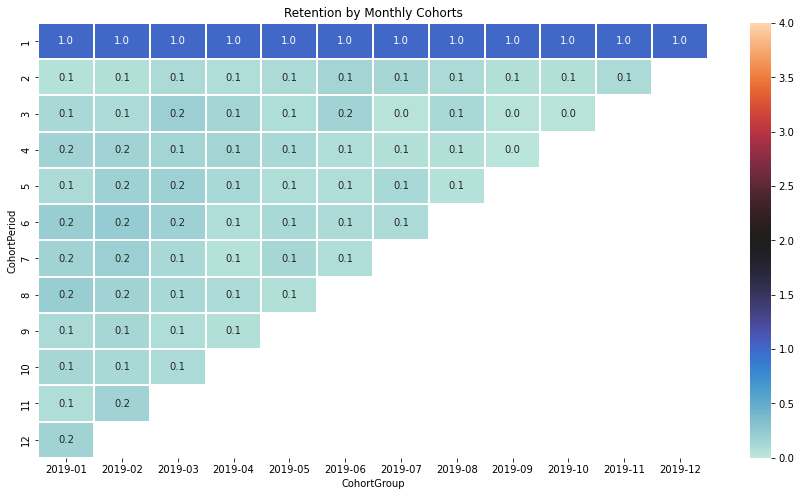

In [340]:
plt.figure(figsize=(15,8))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(data=cust_retention,
            annot = True,
            cmap = "icefire",
            vmin = 0.0,
            vmax = list(cust_retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3)

plt.savefig("Retention By Monthly Cohorts")
plt.show()